## Imports

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import os
import datetime

base_dir = Path(os.getcwd()).resolve().parent
base_dir

WindowsPath('C:/Users/diogo/Desktop/ASTP')

# Leitura e preparação dos dados

In [28]:
# Carregar os dados
df = pd.read_csv(base_dir/"data"/"USEPUINDXD.csv", index_col="observation_date", parse_dates=["observation_date"])

# Filtrar apenas os valores a partir do ano 2000
df = df[df.index >= "2000-01-01"]

# Normalizar os dados para ficar entre 0 e 1
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Definir função para criar sequências de dados (janelas deslizantes)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Definir tamanho da sequência (ex: usar 30 dias passados para prever o próximo valor)
seq_length = 30
X, y = create_sequences(df_scaled, seq_length)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# Criar o modelo CNN

In [ ]:
model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation="relu", padding="same", input_shape=(seq_length, 1)),
    BatchNormalization(),
    Conv1D(filters=64, kernel_size=3, activation="relu", padding="same"),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

# Otimizador Adam com ReduceLROnPlateau para diminuir o learning rate automaticamente
optimizer = AdamW(learning_rate=0.001, weight_decay=0.01)

## Callbacks ##
# Callback para reduzir o learning rate se a validação parar de melhorar
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=0.0001, verbose=1)

# Callback para parar o treino cedo se a validação não melhorar por 10 épocas
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# Callback para guardar o melhor modelo durante o treino
checkpoint = ModelCheckpoint("1", monitor="val_loss", save_best_only=True, verbose=1)

# Callback para visualizar métricas no TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

c:\Users\diogo\Desktop\ASTP\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Treinar a CNN

In [30]:
# Lista final de callbacks
callbacks = [reduce_lr, early_stopping, checkpoint, tensorboard]

# Treinar o modelo com os callbacks
model.compile(optimizer=optimizer, loss=Huber(delta=1.0), metrics=["mae", "mape", "mse"])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
224/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1082 - mae: 0.3043 - mape: 1642.8292 - mse: 0.2433
Epoch 1: val_loss improved from inf to 0.01103, saving model to best_model.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1061 - mae: 0.2998 - mape: 1635.5653 - mse: 0.2385 - val_loss: 0.0110 - val_mae: 0.1016 - val_mape: 75.2089 - val_mse: 0.0221 - learning_rate: 0.0010
Epoch 2/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mae: 0.0502 - mape: 470.4317 - mse: 0.0052
Epoch 2: val_loss improved from 0.01103 to 0.00870, saving model to best_model.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0026 - mae: 0.0501 - mape: 476.2282 - mse: 0.0052 - val_loss: 0.0087 - val_mae: 0.0895 - val_mape: 60.7749 - val_mse: 0.0174 - learning_rate: 0.0010
Epoch 3/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0409 - mape: 1388.9742 - mse: 0.0032
Epoch 3: val_loss improved from 0.00870 to 0.00816, saving model to best_model.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0016 - mae: 0.0409 - mape: 1476.0780 - mse: 0.0032 - val_loss: 0.0082 - val_mae: 0.0776 - val_mape: 53.1113 - val_mse: 0.0164 - learning_rate: 0.0010
Epoch 4/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0392 - mape: 67.9766 - mse: 0.0031
Epoch 4: val_loss improved from 0.00816 to 0.00652, saving model to best_model.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0016 - mae: 0.0392 - mape: 292.5132 - mse: 0.0031 - val_loss: 0.0065 - val_mae: 0.0676 - val_mape: 56.9699 - val_mse: 0.0132 - learning_rate: 0.0010
Epoch 5/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mae: 0.0387 - mape: 25769.7812 - mse: 0.0030
Epoch 5: val_loss did not improve from 0.00652
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0015 - mae: 0.0387 - mape: 25633.5293 - mse: 0.0030 - val_loss: 0.0076 - val_mae: 0.0736 - val_mape: 52.7445 - val_mse: 0.0154 - learning_rate: 0.0010
Epoch 6/100
225/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0383 - mape: 5234.8359 - mse: 0.0029
Epoch 6: val_loss did not improve from 0.00652
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - mae: 0.0383 - mape: 5346.1597 - mse: 0.0029 - val_loss: 0.0079 - val_mae: 0.0750 - val_mape: 52.8578 - val_mse: 0.0160 - learning_rate: 0.0010
Epoch 7/100
224/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae:

230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0016 - mae: 0.0387 - mape: 6341.5894 - mse: 0.0032 - val_loss: 0.0060 - val_mae: 0.0633 - val_mape: 47.7190 - val_mse: 0.0122 - learning_rate: 0.0010
Epoch 9/100
225/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0371 - mape: 12805.2432 - mse: 0.0029
Epoch 9: val_loss did not improve from 0.00604
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - mae: 0.0371 - mape: 12725.3232 - mse: 0.0029 - val_loss: 0.0073 - val_mae: 0.0721 - val_mape: 50.2782 - val_mse: 0.0148 - learning_rate: 0.0010
Epoch 10/100
225/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mae: 0.0364 - mape: 656.0209 - mse: 0.0026
Epoch 10: val_loss improved from 0.00604 to 0.00595, saving model to best_model.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013 - mae: 0.0364 - mape: 662.0577 - mse: 0.0026 - val_loss: 0.0059 - val_mae: 0.0655 - val_mape: 47.0781 - val_mse: 0.0120 - learning_rate: 0.0010
Epoch 11/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0366 - mape: 1643.9930 - mse: 0.0027
Epoch 11: val_loss improved from 0.00595 to 0.00505, saving model to best_model.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0014 - mae: 0.0366 - mape: 1663.8480 - mse: 0.0027 - val_loss: 0.0050 - val_mae: 0.0623 - val_mape: 49.3936 - val_mse: 0.0102 - learning_rate: 0.0010
Epoch 12/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0364 - mape: 955.9527 - mse: 0.0027
Epoch 12: val_loss did not improve from 0.00505
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - mae: 0.0364 - mape: 978.9586 - mse: 0.0027 - val_loss: 0.0057 - val_mae: 0.0629 - val_mape: 49.0724 - val_mse: 0.0119 - learning_rate: 0.0010
Epoch 13/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0359 - mape: 15718.5586 - mse: 0.0027
Epoch 13: val_loss did not improve from 0.00505
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - mae: 0.0360 - mape: 15602.8447 - mse: 0.0027 - val_loss: 0.0060 - val_mae: 0.0638 - val_mape: 47.7136 - val_mse: 0.0121 - learning_rate: 0.0010
Epoch 14/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 -

230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - mae: 0.0374 - mape: 2351.0854 - mse: 0.0028 - val_loss: 0.0047 - val_mae: 0.0613 - val_mape: 48.2072 - val_mse: 0.0095 - learning_rate: 0.0010
Epoch 17/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - mae: 0.0364 - mape: 665.5015 - mse: 0.0026
Epoch 17: val_loss did not improve from 0.00475
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013 - mae: 0.0364 - mape: 797.3800 - mse: 0.0026 - val_loss: 0.0048 - val_mae: 0.0609 - val_mape: 48.4791 - val_mse: 0.0097 - learning_rate: 0.0010
Epoch 18/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mae: 0.0361 - mape: 25912.8379 - mse: 0.0026
Epoch 18: val_loss did not improve from 0.00475
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013 - mae: 0.0361 - mape: 25649.6484 - mse: 0.0026 - val_loss: 0.0068 - val_mae: 0.0728 - val_mape: 50.3334 - val_mse: 0.0137 - learning_rate: 0.0010
Epoch 19/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - 

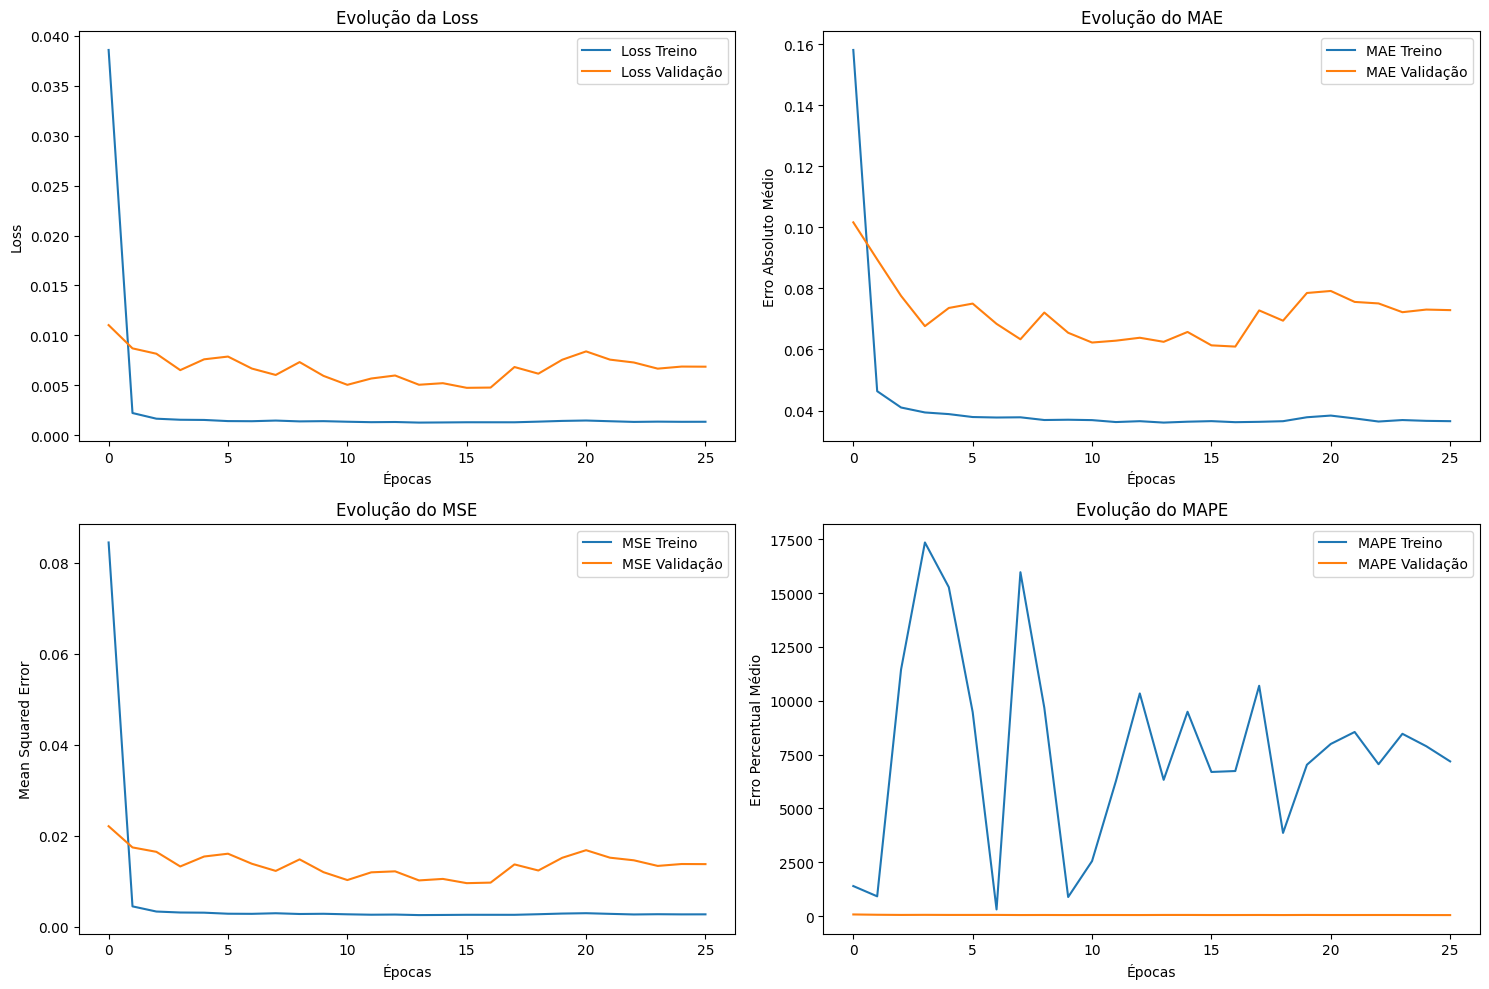

In [32]:
plt.figure(figsize=(15, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history["loss"], label="Loss Treino")
plt.plot(history.history["val_loss"], label="Loss Validação")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.title("Evolução da Loss")

# MAE
plt.subplot(2, 2, 2)
plt.plot(history.history["mae"], label="MAE Treino")
plt.plot(history.history["val_mae"], label="MAE Validação")
plt.xlabel("Épocas")
plt.ylabel("Erro Absoluto Médio")
plt.legend()
plt.title("Evolução do MAE")

# MSE
plt.subplot(2, 2, 3)
plt.plot(history.history["mse"], label="MSE Treino")
plt.plot(history.history["val_mse"], label="MSE Validação")
plt.xlabel("Épocas")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("Evolução do MSE")

# MAPE
plt.subplot(2, 2, 4)
plt.plot(history.history["mape"], label="MAPE Treino")
plt.plot(history.history["val_mape"], label="MAPE Validação")
plt.xlabel("Épocas")
plt.ylabel("Erro Percentual Médio")
plt.legend()
plt.title("Evolução do MAPE")

plt.tight_layout()
plt.show()

In [40]:
# Carregar os pesos do arquivo best_model.h5
model.load_weights('best_model.h5')

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Reverter normalização
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Calcular métricas finais
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print(f"📊 Avaliação do Modelo:")
print(f"✅ MSE: {mse:.4f}")
print(f"✅ MAE: {mae:.4f}")
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAPE: {mape:.2%}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
📊 Avaliação do Modelo:
✅ MSE: 9995.3636
✅ MAE: 62.7619
✅ RMSE: 99.9768
✅ MAPE: 45.85%


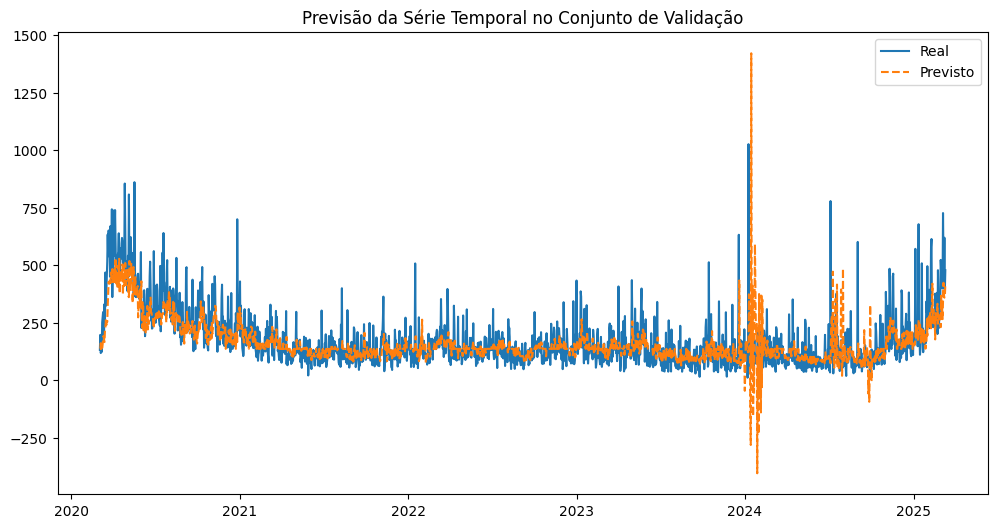

In [41]:
# Visualizar apenas conjunto de teste
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_inv, label="Real")
plt.plot(df.index[-len(y_test):], y_pred_inv, label="Previsto", linestyle="dashed")
plt.legend()
plt.title("Previsão da Série Temporal no Conjunto de Validação")
plt.show()

# Fazer previsões

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

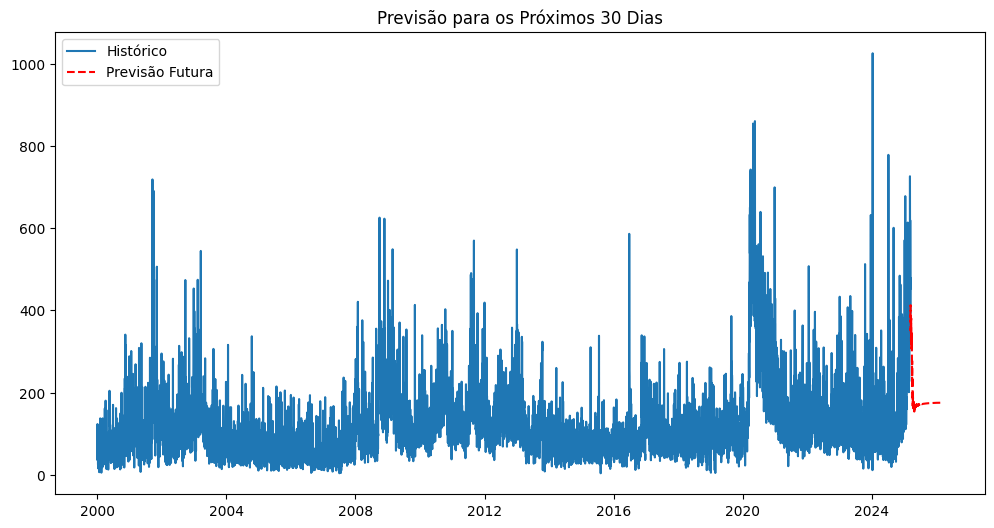

In [ ]:
def forecast_future(model, data, days, seq_length):
    last_seq = data[-seq_length:]  # Últimos `seq_length` valores como entrada
    predictions = []

    for _ in range(days):
        pred = model.predict(last_seq.reshape(1, seq_length, 1))[0, 0]  # Fazer previsão
        predictions.append(pred)
        last_seq = np.roll(last_seq, -1)  # Deslocar a sequência para frente
        last_seq[-1] = pred  # Adicionar a nova previsão

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

dias = 365

# Fazer previsão para os próximos 30 dias
future_pred = forecast_future(model, df_scaled, days=dias, seq_length=seq_length)

# Criar datas futuras
future_dates = pd.date_range(start=df.index[-1], periods=dias, freq="D")

# Visualizar previsão futura
plt.figure(figsize=(12, 6))
plt.plot(df.index, scaler.inverse_transform(df_scaled), label="Histórico")
plt.plot(future_dates, future_pred, label="Previsão Futura", linestyle="dashed", color="red")
plt.legend()
plt.title(f"Previsão para os Próximos {dias} Dias")
plt.show()